In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import thanos
from thanos.gen import *
from thanos.util import *
from thanos.operator import *

## Repeatability

In [3]:
X = RandomVariable('gamma', seeded_gen(1), 1.0, 2.0)

b = ConstantVariable(X) # A constant variable from a gamma distribution

# variables as iterator generators
for _, sample, var in zip(range(3), b, X):
    print(sample, var)

print("reseeding")
b.reseed(seeded_gen(123))
for _, sample in zip(range(3), b):
    print(sample)

2.1460580527450777 0.6169062882505687
2.1460580527450777 10.750873745216253
2.1460580527450777 0.7328542257996639
reseeding
1.1939449902453037
1.1939449902453037
1.1939449902453037


## Composability

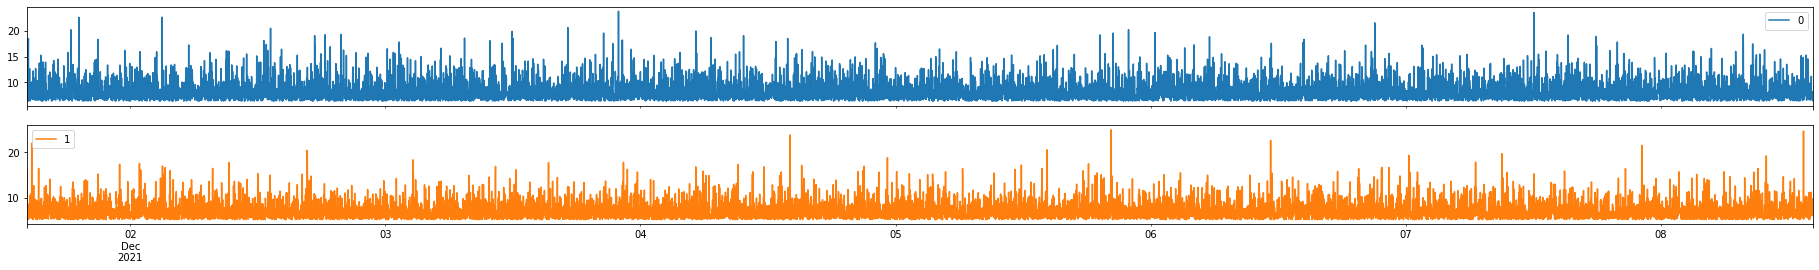

In [4]:
seed = seeded_gen(123)
Y = op(operator.add, 
       ConstantVariable(RandomVariable('uniform', seed, 0.0, 10.0)), 
       RandomVariable('gamma', seed, 1.0, 2.0))

plot_examples(Y, 2)

## Repeatability

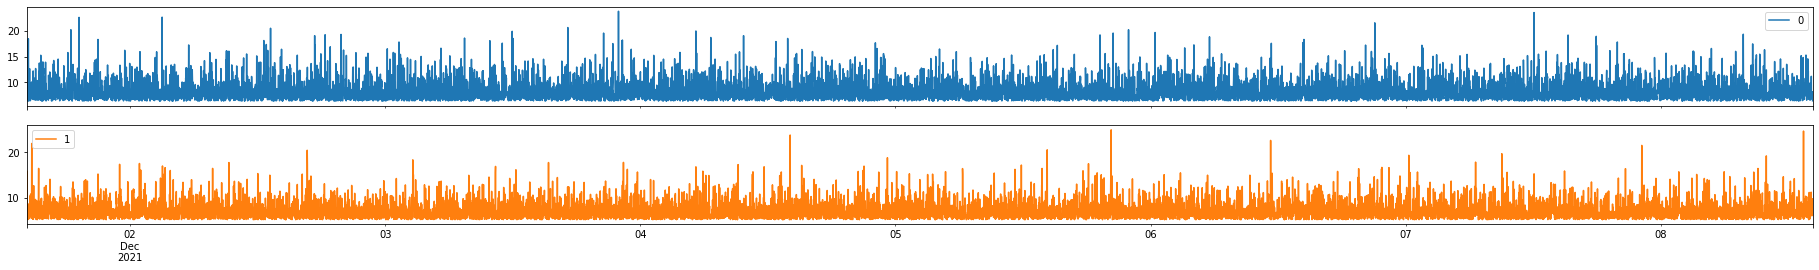

In [5]:
Y.reset()
plot_examples(Y, 2)

## Generation Tree

In [6]:
print_optree(Y *2 + 10)

op add
	op mul
		op add
			ConstantVariable 5.118216247002567
				RandomVariable uniform(0.0,10.0)
			RandomVariable gamma(1.0,2.0)
		ConstantVariable 2
	ConstantVariable 10


## Fluent Interface (Pandas-like)

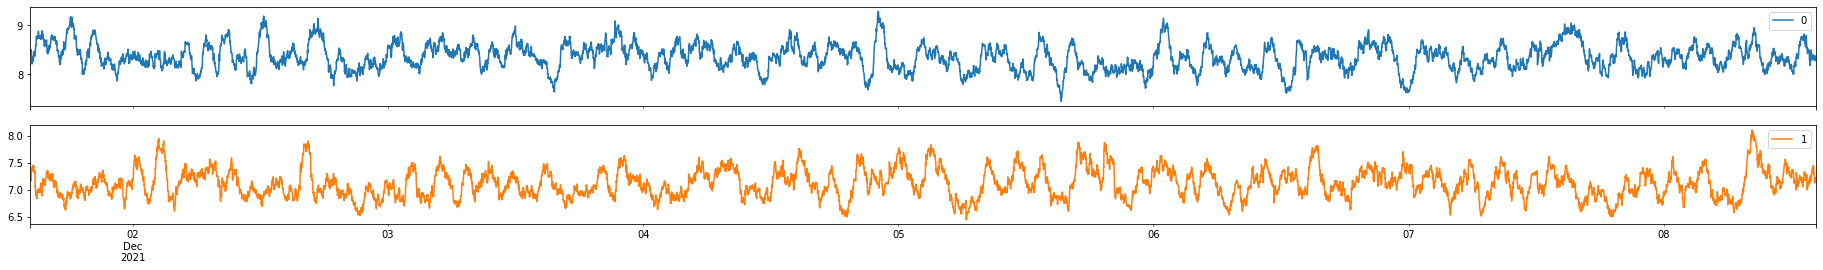

In [7]:
Y_smooth = Y.reset().window(60, sliding=True).apply(np.mean)
plot_examples(Y_smooth, 2)

## Streaming With Pytorch

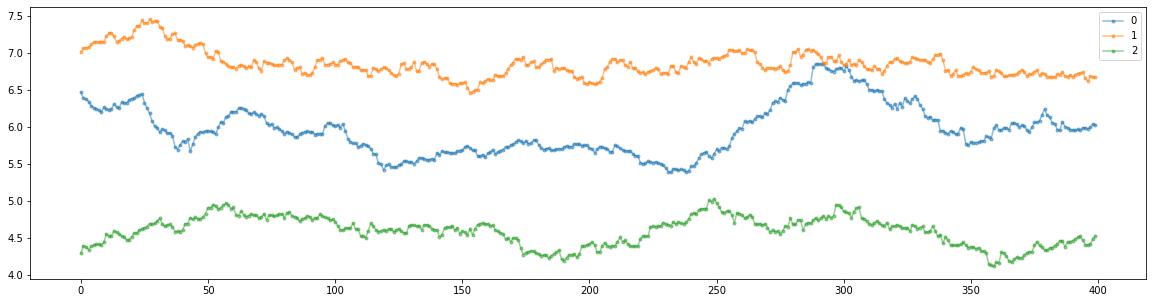

In [8]:
# make this more visual by adding different kinds of series, then injecting the anomalies
%matplotlib inline
from thanos.SyntheticDataset import *
ds = SyntheticDataset(Y_smooth.reset(), seeded_gen(5678), numdims=3)
animate_plot(ds)

# Simple Signals

## Seasonality and Trend

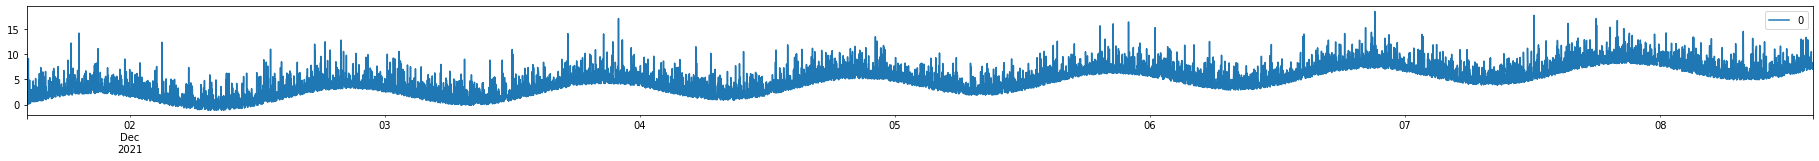

In [9]:
seasonal = op(operator.add,
              RandomVariable('gamma', seed, 1.0, 1.5), 
              Seasonality() * ConstantVariable(RandomVariable('uniform', seed, 0.0, 3.0)))
trended = seasonal + Trend(rate = 1/(60*24))
plot_examples(trended)

## Business Hours

# Use Cases

## Anomaly Injection

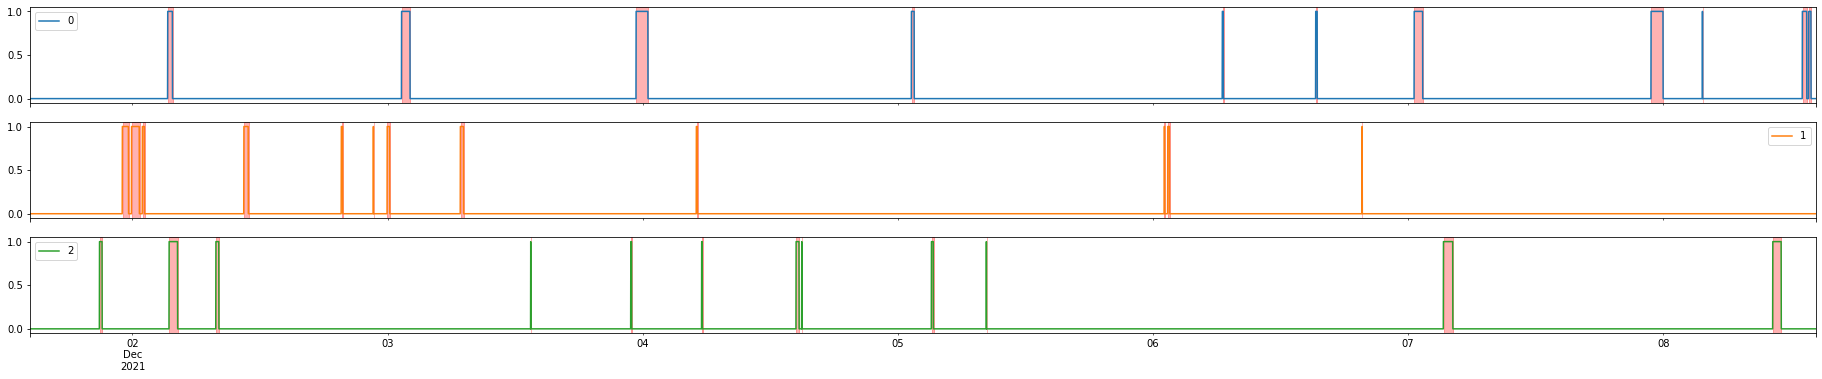

In [11]:
anomalies = BinMarkovAnomaly(seed, p_on = 0.001, p_off = 0.05)
plot_examples(anomalies, 3)

### Mixing it all together

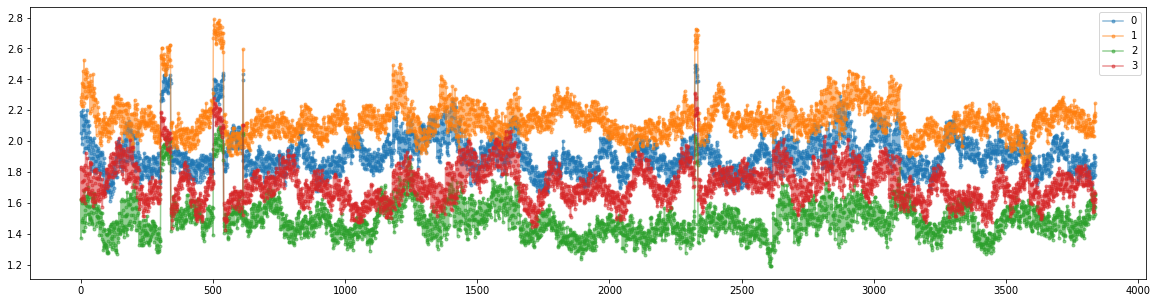

In [12]:
composed_example = ReBasis(np.array([0.5, 0.3, 0.1]), [BinMarkovAnomaly(seed, p_on = 0.001, p_off = 0.05), Y_smooth, business.reset()])
animate_plot(SyntheticDataset(composed_example, seeded_gen(5678), numdims=4), batch_size = 128, batch_count = 30)

# Advanced Signal Examples

These examples are from the public service now documentation of signal classification as documented in [ITOM-Health](https://docs.servicenow.com/bundle/quebec-it-operations-management/page/product/event-management/concept/operational-intelligence-overview.html)

## Positive Clipped Noisy

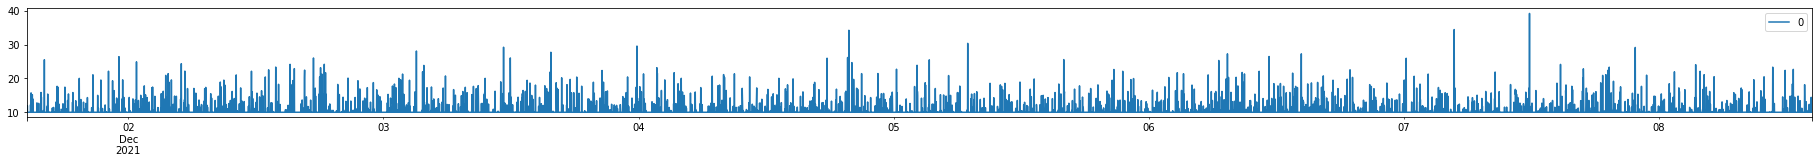

In [13]:
positive_clipped_noisy = RandomVariable('gamma', seed, 2.0, 3.0).apply(np.clip, 10, np.inf)
plot_examples(positive_clipped_noisy)

## Accumulator

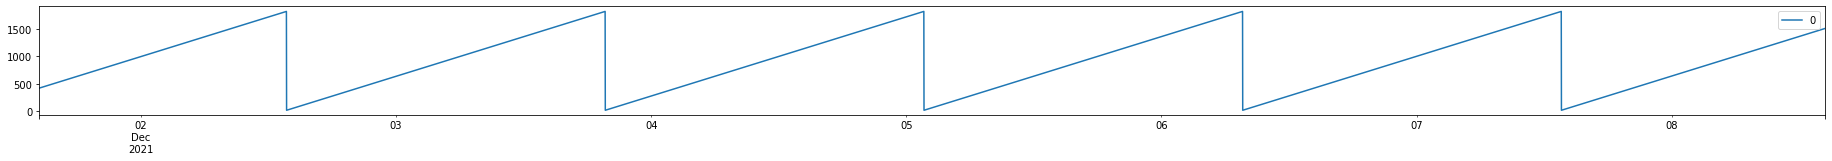

In [14]:
accumulator = Trend(rate=1, initial_value=ConstantVariable(RandomVariable('uniform', seed, 0, 2000)), maximum=ConstantVariable(RandomVariable('uniform', seed, 1500, 2000)), minimum=20)
plot_examples(accumulator)

## MultiNomial

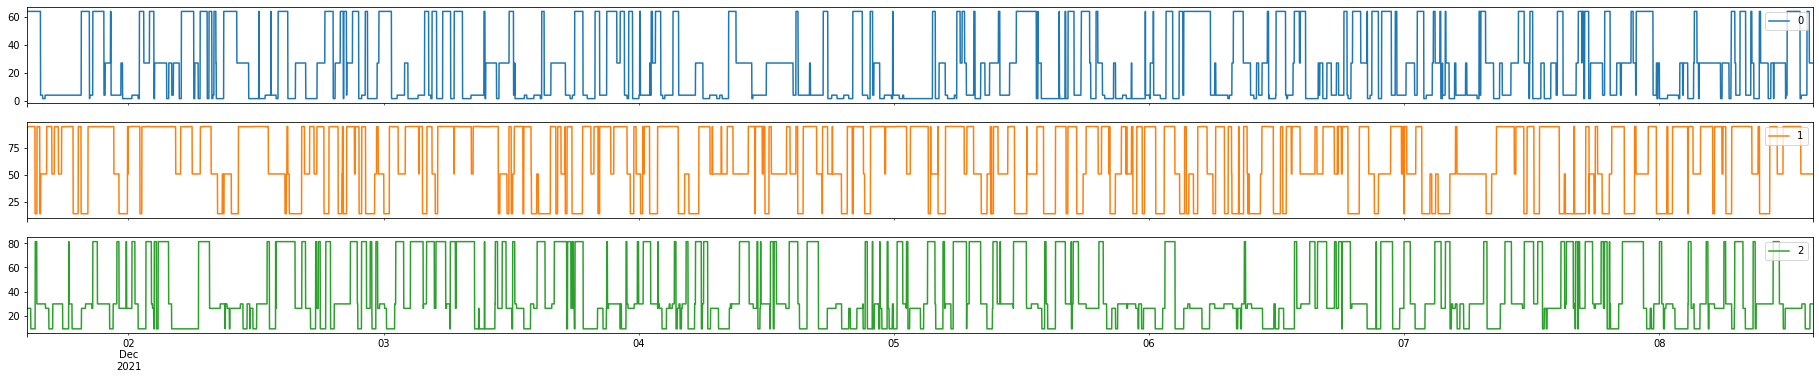

In [15]:
statecount = 4
plot_examples(StateSelector(RandomVariable('gamma', seed, 1, 2)*10,
                            RandomVariable('integers', seed, 0, statecount),
                            [ConstantVariable(RandomVariable('uniform', seed, 0, 100)) for i in range(statecount) ]),
              3)